In [1]:
from transformers import BertForSequenceClassification
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F
import importlib
from transformers import BertModel, BertTokenizer

from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rd81\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
n_labels = 2

epochs = 10
lr = 0.00001
manual_loss= False
batch_sizes = 100
max_len = 150

loss = 'cross_ent'

run_data = {}

In [3]:
class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df,dataset='prop'):
        
        tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        
        if dataset == 'prop':
            target_col = 'propaganda'
            text_col = 'original_sentence_no_tags'
            
            self.labels=torch.tensor([label for label in df[target_col]])

            
        if dataset == 'snip':
            label_to_id = {'flag_waving': 0, 'exaggeration,minimisation': 1, 'causal_oversimplification': 2, 'name_calling,labeling': 3, 'repetition': 4, 'doubt': 5, 'not_propaganda': 6, 'loaded_language': 7, 'appeal_to_fear_prejudice': 8}
            
            target_col = 'snippet_label'
            text_col = 'snippet_original'
            self.labels=torch.tensor([label_to_id[label] for label in df[target_col]])
            
        self.texts=[tokenizer(text,padding='max_length',max_length=150,truncation=True,return_tensors="pt") for text in df[text_col]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y


def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [4]:
class BertClassifier(nn.Module):

    def __init__(self,dropout=0.5,num_classes=2):
        super(BertClassifier, self).__init__()

        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        _, pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

In [7]:
# wills
epochs = 16
lr = 5e-6
batch_size=50
max_len=150

In [8]:
import random 
train_df_original, val_df_original = get_processed_data(dev=False)

train_data = CustomPropagandaDataset_vanilla(train_df_original)
val_data = CustomPropagandaDataset_vanilla(val_df_original)

train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=50,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=50)

# lrs = [random.uniform(5e-05, 8e-05) for _ in range(10)]

# lrs= [7.1984e-05]


    
model=BertClassifier(num_classes=n_labels).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

            output_1=model(input_id,mask)

            batch_loss_1=criterion(output_1,train_label.long())
            total_loss_train +=batch_loss_1.item()

            acc=(output_1.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss_1.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output_2= model(input_id,mask)

                batch_loss_2=criterion(output_2,val_label.long())

                total_loss_val+=batch_loss_2.item()

                acc=(output_2.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        
        if epoch_num == epochs-1:
            print('____________')
            print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
            print('____________')



100%|██████████| 52/52 [00:29<00:00,  1.73it/s]


Epochs: 1 | Train Loss: 0.014 | Train Accuracy: 0.548
Val loss: 0.014 | Val Accuracy: 0.544


100%|██████████| 52/52 [00:30<00:00,  1.69it/s]


Epochs: 2 | Train Loss: 0.014 | Train Accuracy: 0.580
Val loss: 0.014 | Val Accuracy: 0.606


100%|██████████| 52/52 [00:30<00:00,  1.68it/s]


Epochs: 3 | Train Loss: 0.013 | Train Accuracy: 0.618
Val loss: 0.013 | Val Accuracy: 0.614


100%|██████████| 52/52 [00:31<00:00,  1.67it/s]


Epochs: 4 | Train Loss: 0.013 | Train Accuracy: 0.641
Val loss: 0.013 | Val Accuracy: 0.613


100%|██████████| 52/52 [00:31<00:00,  1.67it/s]


Epochs: 5 | Train Loss: 0.013 | Train Accuracy: 0.653
Val loss: 0.013 | Val Accuracy: 0.611


100%|██████████| 52/52 [00:31<00:00,  1.68it/s]


Epochs: 6 | Train Loss: 0.013 | Train Accuracy: 0.668
Val loss: 0.013 | Val Accuracy: 0.639


100%|██████████| 52/52 [00:31<00:00,  1.68it/s]


Epochs: 7 | Train Loss: 0.012 | Train Accuracy: 0.695
Val loss: 0.013 | Val Accuracy: 0.614


100%|██████████| 52/52 [00:30<00:00,  1.68it/s]


Epochs: 8 | Train Loss: 0.012 | Train Accuracy: 0.711
Val loss: 0.013 | Val Accuracy: 0.630


100%|██████████| 52/52 [00:30<00:00,  1.68it/s]


Epochs: 9 | Train Loss: 0.011 | Train Accuracy: 0.759
Val loss: 0.013 | Val Accuracy: 0.653


100%|██████████| 52/52 [00:30<00:00,  1.68it/s]


Epochs: 10 | Train Loss: 0.010 | Train Accuracy: 0.776
Val loss: 0.014 | Val Accuracy: 0.644


100%|██████████| 52/52 [00:31<00:00,  1.68it/s]


Epochs: 11 | Train Loss: 0.009 | Train Accuracy: 0.809
Val loss: 0.014 | Val Accuracy: 0.655


100%|██████████| 52/52 [00:30<00:00,  1.68it/s]


Epochs: 12 | Train Loss: 0.008 | Train Accuracy: 0.844
Val loss: 0.014 | Val Accuracy: 0.655


100%|██████████| 52/52 [00:30<00:00,  1.68it/s]


Epochs: 13 | Train Loss: 0.007 | Train Accuracy: 0.853
Val loss: 0.015 | Val Accuracy: 0.656


100%|██████████| 52/52 [00:30<00:00,  1.68it/s]


Epochs: 14 | Train Loss: 0.006 | Train Accuracy: 0.883
Val loss: 0.015 | Val Accuracy: 0.641


 23%|██▎       | 12/52 [00:07<00:24,  1.65it/s]

: 

In [ ]:
train_data[0][1]

array(0, dtype=int64)

In [21]:
include_dev=False
batch_size_train = 100
batch_size_test = 100
batch_size_dev = 100

if include_dev:
    train_df, val_df, test_df = get_processed_data(dev=True)
    
    train_df= get_cols_for_bert(train_df, 'prop')
    val_df= get_cols_for_bert(val_df, 'prop')
    test_df= get_cols_for_bert(test_df, 'prop')
    
    train_input_embeddings_labelled = format_and_tokenise_from_df(train_df, max_len=64)
    val_input_embeddings_labelled = format_and_tokenise_from_df(val_df, max_len=64)
    test_input_embeddings_labelled = format_and_tokenise_from_df(test_df, max_len=64)
    
    train_dataset = CustomPropagandaDataset(train_input_embeddings_labelled)
    test_dataset = CustomPropagandaDataset(test_input_embeddings_labelled)
    val_dataset = CustomPropagandaDataset(val_input_embeddings_labelled)
    


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_dev, shuffle=True)
    
    
else:
    train_df_original, val_df_original = get_processed_data(dev=False)
    
    train_df= get_cols_for_bert(train_df_original, 'prop')
    val_df= get_cols_for_bert(val_df_original, 'prop')
    
    train_input_embeddings_labelled = format_and_tokenise_from_df(train_df, max_len=64)
    val_input_embeddings_labelled = format_and_tokenise_from_df(val_df, max_len=64)
    
    train_dataset = CustomPropagandaDataset(train_input_embeddings_labelled)
    val_dataset = CustomPropagandaDataset(val_input_embeddings_labelled)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_dev)
    

In [22]:
model = BertClassifier(num_classes=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(batch['input_ids'], batch['attention_mask'])
        
        batch_loss = criterion(outputs, batch['labels'].long())
        
        train_running_losses.append(batch_loss.item())
        
        acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
        train_correct += acc
        train_total += len(batch['input_ids'])
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
                          
    print(f'TRAIN: Epoch [{epoch + 1}/{epochs}] Loss: {sum(train_running_losses) / len(train_running_losses)} Acc: {train_correct / train_total}')
    
    model.eval()
    with torch.no_grad():
        
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(batch['input_ids'], batch['attention_mask'])
            
            batch_loss = criterion(outputs, batch['labels'].long())
            
            val_running_losses.append(batch_loss.item())
            
            acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
            
            val_correct += acc
            val_total += len(batch['input_ids'])
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        
        print(f'VAL: Epoch [{epoch + 1}/{epochs}] Loss: {sum(val_running_losses) / len(val_running_losses)} Acc: {val_correct / val_total}')

TRAIN: Epoch [1/10] Loss: 0.6860665724827693 Acc: 0.558984375


VAL: Epoch [1/10] Loss: 0.6647348574229649 Acc: 0.6171875


TRAIN: Epoch [2/10] Loss: 0.6749836710783151 Acc: 0.593359375


VAL: Epoch [2/10] Loss: 0.6580449513026646 Acc: 0.6171875


TRAIN: Epoch [3/10] Loss: 0.6610818596986624 Acc: 0.61953125


VAL: Epoch [3/10] Loss: 0.6571980459349496 Acc: 0.603125


TRAIN: Epoch [4/10] Loss: 0.6480127252065219 Acc: 0.6359375


VAL: Epoch [4/10] Loss: 0.6461886082376752 Acc: 0.6296875


TRAIN: Epoch [5/10] Loss: 0.6335206100573907 Acc: 0.659765625


VAL: Epoch [5/10] Loss: 0.6464867166110447 Acc: 0.640625


TRAIN: Epoch [6/10] Loss: 0.6017588950120486 Acc: 0.693359375


VAL: Epoch [6/10] Loss: 0.6268964920725141 Acc: 0.65


TRAIN: Epoch [7/10] Loss: 0.5583059730438086 Acc: 0.730078125


VAL: Epoch [7/10] Loss: 0.6518245935440063 Acc: 0.6328125


 81%|████████  | 21/26 [00:10<00:02,  2.01it/s]

: 

In [13]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        if manual_loss:
            loss = criterion(outputs.logits, batch['labels'])
        else:
            loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        _, indices = torch.max(outputs['logits'], dim=1)
        predicted_labels = indices
        train_total += batch['labels'].size(0)
        train_correct += (predicted_labels == batch['labels']).sum().item()
        train_running_losses.append(loss.item())
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
    print(f'TRAIN: Epoch [{epoch+1}/{epochs}] Loss: {sum(train_running_losses)/len(train_running_losses)} Acc: {train_correct/train_total}')
    
    model.eval()
    with torch.no_grad():
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            
            _, indices = torch.max(outputs['logits'], dim=1)
            predicted_labels = indices
            
            val_total += batch['labels'].size(0)
            val_correct += (predicted_labels == batch['labels']).sum().item()
            val_running_losses.append(loss.item())
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        print(f'VAL: Epoch [{epoch+1}/{epochs}] Loss: {sum(val_running_losses)/len(val_running_losses)} Acc: {val_correct/val_total}')
    
    if include_dev:
        print('TESTING...')
        test_losses = []
        test_accuracy = []
        
        model.eval()
        with torch.no_grad():
            test_running_losses = []
            test_total = 0
            test_correct = 0
            
            for batch in test_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                
                _, indices = torch.max(outputs['logits'], dim=1)
                predicted_labels = indices
                
                test_total += batch['labels'].size(0)
                test_correct += (predicted_labels == batch['labels']).sum().item()
                test_running_losses.append(loss.item())
            
            test_losses.append(sum(test_running_losses) / len(test_running_losses))
            test_accuracy.append(test_correct / test_total)
            print(f'TEST: Epoch [{epoch+1}/{epochs}] Loss: {sum(test_running_losses)/len(test_running_losses)} Acc: {test_correct/test_total}')
 
plot_training(train_losses, train_accuracy, val_losses, val_accuracy)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'CustomPropagandaDataset' object has no attribute 'attention_masks'

TRAIN: Epoch [1/12] Loss: 0.6840397004038096 Acc: 0.548046875


VAL: Epoch [1/12] Loss: 0.6656122401356697 Acc: 0.571875


TRAIN: Epoch [2/12] Loss: 0.66269860137254 Acc: 0.600390625


VAL: Epoch [2/12] Loss: 0.6540285274386406 Acc: 0.6265625


TRAIN: Epoch [3/12] Loss: 0.6620131636038422 Acc: 0.61171875


VAL: Epoch [3/12] Loss: 0.6431932426989079 Acc: 0.6328125


TRAIN: Epoch [4/12] Loss: 0.6421731205657124 Acc: 0.636328125


VAL: Epoch [4/12] Loss: 0.6350597187876701 Acc: 0.64375


TRAIN: Epoch [5/12] Loss: 0.5912784239277243 Acc: 0.696484375


VAL: Epoch [5/12] Loss: 0.6127740614116192 Acc: 0.6671875


TRAIN: Epoch [6/12] Loss: 0.49269067458808424 Acc: 0.7671875


VAL: Epoch [6/12] Loss: 0.6166141651570797 Acc: 0.68125


TRAIN: Epoch [7/12] Loss: 0.34874654598534105 Acc: 0.8609375


VAL: Epoch [7/12] Loss: 0.6932690270245075 Acc: 0.671875


TRAIN: Epoch [8/12] Loss: 0.2388269007205963 Acc: 0.911328125


VAL: Epoch [8/12] Loss: 0.8658045962452888 Acc: 0.665625


TRAIN: Epoch [9/12] Loss: 0.15504370096605272 Acc: 0.948046875


VAL: Epoch [9/12] Loss: 1.2236308328807355 Acc: 0.625


TRAIN: Epoch [10/12] Loss: 0.1287789208930917 Acc: 0.9515625


VAL: Epoch [10/12] Loss: 1.003816683590412 Acc: 0.6625


TRAIN: Epoch [11/12] Loss: 0.08907036123564467 Acc: 0.97421875


VAL: Epoch [11/12] Loss: 1.0944314870983363 Acc: 0.6546875


TRAIN: Epoch [12/12] Loss: 0.07408369309268892 Acc: 0.976171875


VAL: Epoch [12/12] Loss: 1.1286551743745803 Acc: 0.6484375


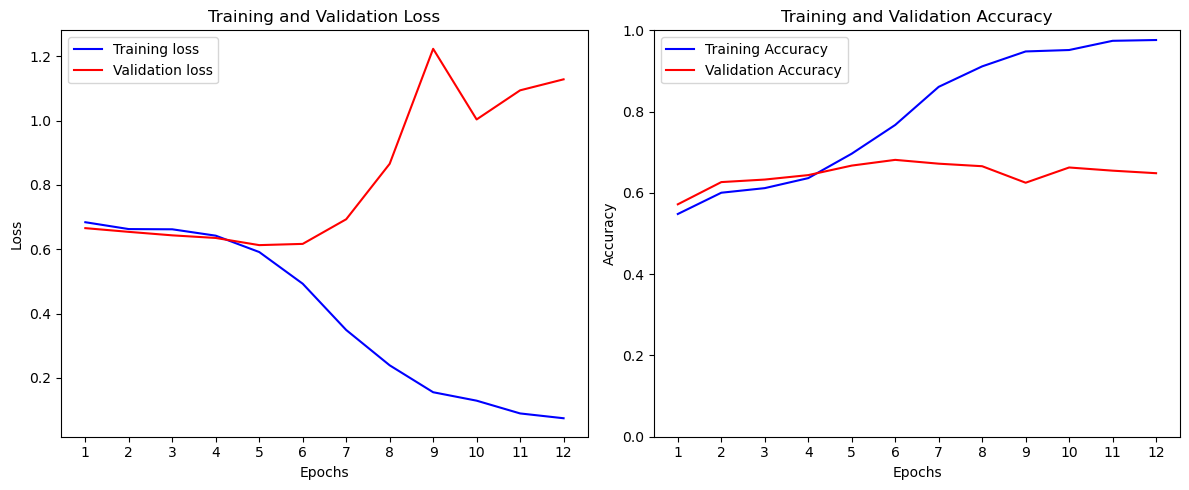

TRAIN: Epoch [1/12] Loss: 0.6928375825285912 Acc: 0.50703125


VAL: Epoch [1/12] Loss: 0.6872401252388954 Acc: 0.6140625


TRAIN: Epoch [2/12] Loss: 0.6774702917784452 Acc: 0.61015625


VAL: Epoch [2/12] Loss: 0.6716835871338844 Acc: 0.628125


TRAIN: Epoch [3/12] Loss: 0.662690793350339 Acc: 0.63359375


VAL: Epoch [3/12] Loss: 0.6589634835720062 Acc: 0.621875


TRAIN: Epoch [4/12] Loss: 0.642702867090702 Acc: 0.6609375


VAL: Epoch [4/12] Loss: 0.6621029630303383 Acc: 0.60625


TRAIN: Epoch [5/12] Loss: 0.6210170639678836 Acc: 0.690625


VAL: Epoch [5/12] Loss: 0.7048458978533745 Acc: 0.5671875


TRAIN: Epoch [6/12] Loss: 0.5937637988477945 Acc: 0.726171875


VAL: Epoch [6/12] Loss: 0.6531563505530358 Acc: 0.634375


TRAIN: Epoch [7/12] Loss: 0.5531927201896906 Acc: 0.769140625


VAL: Epoch [7/12] Loss: 0.6327591471374034 Acc: 0.665625


TRAIN: Epoch [8/12] Loss: 0.5268130552023649 Acc: 0.795703125


VAL: Epoch [8/12] Loss: 0.6157613337039948 Acc: 0.6875


TRAIN: Epoch [9/12] Loss: 0.4915252786129713 Acc: 0.83046875


VAL: Epoch [9/12] Loss: 0.6146183922886849 Acc: 0.6890625


TRAIN: Epoch [10/12] Loss: 0.4646534912288189 Acc: 0.860546875


VAL: Epoch [10/12] Loss: 0.648902852088213 Acc: 0.6546875


TRAIN: Epoch [11/12] Loss: 0.4573596762493253 Acc: 0.863671875


VAL: Epoch [11/12] Loss: 0.6556538298726082 Acc: 0.65


TRAIN: Epoch [12/12] Loss: 0.4614076489582658 Acc: 0.85703125


VAL: Epoch [12/12] Loss: 0.6919141829013824 Acc: 0.615625


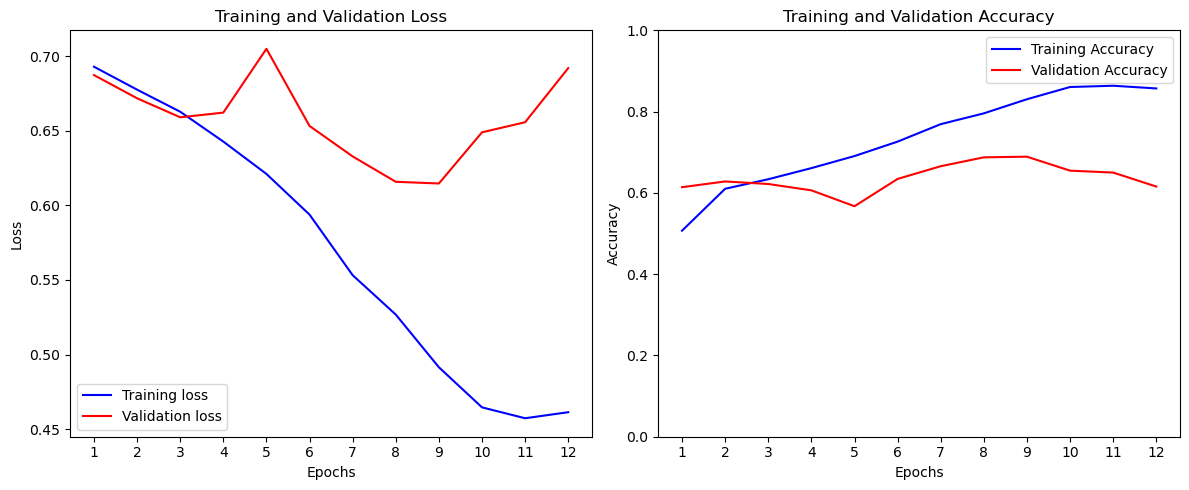

In [8]:
class BertClassifier_2(nn.Module):
    def __init__(self, dropout=0.5, num_classes=2):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768, 128)
        self.relu=nn.ReLU()
        self.linear_2 = nn.Linear(128, num_classes)

        if num_classes == 2:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_layer, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        relu_applied = self.relu(linear_output_1)
        dropout_l = self.dropout(relu_applied)
        linear_output_2 = self.linear_2(dropout_l)
        final_layer = self.activation(linear_output_2)
        return final_layer
    
    
model=BertClassifier_2(num_classes=n_labels)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

model.to(device)

for epoch in range(epochs):
    train_running_losses = []
    train_total = 0
    train_correct = 0
    
    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch['input_ids'], batch['attention_mask'])
        batch_loss = criterion(outputs, batch['labels'].long())
        train_running_losses.append(batch_loss.item())
        
        acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
        train_correct += acc
        train_total += len(batch['input_ids'])
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    train_losses.append(sum(train_running_losses) / len(train_running_losses))
    train_accuracy.append(train_correct / train_total)
    print(f'TRAIN: Epoch [{epoch + 1}/{epochs}] Loss: {sum(train_running_losses) / len(train_running_losses)} Acc: {train_correct / train_total}')
    
    model.eval()
    with torch.no_grad():
        val_running_losses = []
        val_total = 0
        val_correct = 0
        
        for batch in tqdm(val_dataloader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            batch_loss = criterion(outputs, batch['labels'].long())
            val_running_losses.append(batch_loss.item())
            
            acc = (outputs.argmax(dim=1) == batch['labels']).sum().item()
            val_correct += acc
            val_total += len(batch['input_ids'])
        
        val_losses.append(sum(val_running_losses) / len(val_running_losses))
        val_accuracy.append(val_correct / val_total)
        print(f'VAL: Epoch [{epoch + 1}/{epochs}] Loss: {sum(val_running_losses) / len(val_running_losses)} Acc: {val_correct / val_total}')

plot_training(train_losses, train_accuracy, val_losses, val_accuracy)